In [99]:
# math and data packages
import pandas as pd
import numpy as np
import math

# charting and graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

# os and file types
import os
import sys
import datetime as dt
import json
import csv

# images and display
# import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# survey data
# date issue to fix year one (put from dd.mm.yy format -> yyyy-mm-dd format)
# date issue to fix year two (data looks fine - check with analyst)
# commune issue to fix (cdf in way too many communes)
spd=pd.read_csv("resources/survey_data_lists_02_22.csv")
spd["date"] = pd.to_datetime(spd["date"])
spd = spd[spd["date"] < "2021-11-01"].copy()
spd["month"] = spd["date"].dt.month

In [100]:
# functions that will be used in each subgroup, part of analysis and in the whole data

# number of surveys per year per location (needs loc_date column)

def nSamplesPerYearPlace(x):
    """returns samples per year for each location
    param x: df
    """
    return x.loc_date.nunique()

def top_y_group(x,y,col):
    """returns list of top y number of unique elements in column col in passed df x
    :param x: df
    :param y: int, final rank to include in list of top most common elements
    :param col: str, name of column to sort according to frequency of values
    example: top_y_group(dataframe, 10, "species") returns top 10 values in species column of provided dataframe.
    """
    return x[col].value_counts()[:y].index.tolist()

def red_list(x,y, column_name="biogeo"):
    """returns dataframe of species with the useful redlist codes
    of the species in passed df x in biogeo region y.
    :param x: df
    :param y: str, bioregion (ju, mp, na)
    :e.g.: {"nt": [carduus-crispus, alcea-rosea], vu = ["cardamine-hirsuta"], LC = ....}
    """
    int_data = x.loc[x["biogeo"] == y]
    for i in ["VU", "NT", "LC", "EN", "NE", "DD"]:
        if y == "ju":
            int_data.loc[int_data["rju"]==i]
        elif y == "mp":
            int_data.loc[int_data["rmp"]==i]
        else:
            int_data.loc[int_data["rch"]==i]
    return int_data
# returns a dataframe composed of the non-native status
def no_redlist_status(x, ni="ni", wl="WL", bl="BL", inv="inv"):
    nix = x.loc[x[ni] == ni]
    wlx = x.loc[x[inv] == wl] 
    blx = x.loc[x[inv] == bl]
    int_data = nix.append(wlx)
    data = int_data.append(blx)
    return data

In [101]:
# functions

# species per location/date combination (uniquely defines a sample)
def nSpeciesPerSample(data):
    return data.groupby(["date", "place"], as_index=False).species.count()

def aSpeciesPerSample(data, species=[]):
    """The per sample data for a species
    """
    new_data = nSpeciesPerSample(data[data["species"].isin(species)])
    new_data.rename(columns={"species":species[0]}, inplace=True)
    return new_data

# species per location
def speciesPlaceNsamps(data):
    return data.groupby(["species", "place"], as_index=False).loc_date.nunique()

def pivot_this(data, colnames, index, column, value):
    return data[colnames].pivot(index=index, columns=column, values=value).fillna(0)

def speciesPerLocation(data,colnames, index="species",columns="place",values="loc_date"):
    """Uses speciesPlaceNsamps to return a matrix of species and locations with value of
    number of times identified at that location
    """
    return pivot_this(data, colnames, index, columns, values)

def speciesPlace(species_data, soi):
    """Uses speciesPerlocation to report on one species"""
    return species_data.loc[soi, (species_data.loc[soi] > 0)]

In [102]:
# separate summary observations in each year
spd1 = spd.loc[spd.year == 1].copy()
spd1.fillna(0).copy()
spd2 = spd.loc[(spd["year"] == 2)&(spd["date"] < "2021-10-01")].copy()
spd2.fillna(0).copy()

# top 15 genus and species in y1, y2
spd1sp15 = top_y_species(spd1,15)
spd2sp15 = top_y_species(spd2,15)
sp1 = spd1.species.nunique()
sp2 = spd2.species.nunique()
# top 15 non native genus and species in y1, y2

spd1nr = no_redlist_status(spd1)
spd2nr = no_redlist_status(spd2)

spd1nrsp15 = top_y_species(spd1nr,15)
spd2nrsp15 = top_y_species(spd2nr,15)
sp1nr = spd1nr.species.nunique()

# top 15 native fam, genus, species in y1, y2  
spd1rl = spd1[spd1["fam"]!='X']
spd2rl = spd2[spd2["fam"]!='X']
spd1rlfam = top_y_group(spd1,15,"fam")
spd2rlfam = top_y_group(spd2,15, "fam")
# spd1nrg15 = top_y_species(spd1nr,15)

In [103]:
def make_a_summary_table(ax, data,colLabels, a_color="black", font_size=12, s_et_bottom_row=True):
    
    """Formats matplotlib table object.

    Args:
    ax: object: matplotlib table object
    data: array: the 2d array used to generate the table object
    cols_to_use: array: the list of column names
    a_color: str: matplotlib named color, face and edgecolor of table cells
    font_size: int: the font size for the table cells
    s_et_bottom_row: bool: whether or not to draw bottom line on the last row

    Returns:
    The table object formatted.
    """

    ax.auto_set_font_size(False)
    the_cells = ax.get_celld()

    line_color = colors.to_rgba(a_color)
    banded_color = (*line_color[:-1], 0.1)

    # the different areas of formatting
    top_row = [(0, i) for i in np.arange(len(colLabels))]
    bottom_row = [(len(data), i) for i in np.arange(len(colLabels))]
    data_rows = [x for x in list(the_cells.keys()) if x not in top_row]
        
    for a_cell in top_row:
        ax[a_cell].visible_edges = "B"
        ax[a_cell].set_text_props(**{"fontsize": font_size})
        ax[a_cell].set_edgecolor("black")
        ax[a_cell].PAD = .2
        ax[a_cell].set_linewidth = 1
        ax[a_cell].set_height(.5 / (len(data)))

    for a_cell in data_rows:
        ax[a_cell].set_height(.5 / (len(data)))
        ax[a_cell].visible_edges = "BT"
        ax[a_cell].set_text_props(**{"fontsize": font_size})
        ax[a_cell].set_edgecolor(banded_color)
        ax[a_cell]._text.set_horizontalalignment("center")
        ax[a_cell].set_linewidth = .1

    if s_et_bottom_row is True:
        
        for a_cell in bottom_row:
            ax[a_cell].visible_edges = "B"
            ax[a_cell].set_edgecolor(line_color)
            ax[a_cell].set_linewidth = 1

    return ax



def a_simple_formatted_table(ax,data,colLabels=[], a_color="black", colWidths=[], bbox=[], **kwargs):
    """Makes a table with rows from a matplotlib axes object and a 2d array. Header row is
    spererated from table body by a thicker black line. 
    
    :param ax: An axes
    :type ax: matplotlib axes
    :param data: An array of the table values not including column names or labels
    :type data: array
    :param colLabels: The labels for the data table columns
    :type colLabels: array
    :param a_color: The color of the cell borders
    :type a_color: str
    :param colWidths: The width of each column in fractions of 1
    :type colWdiths: array, x < 1
    :param bbox: The location of the table in figure space
    :type bbox: array
    :return: A table on the provided axis
    :rtype: matplotlib.axes
    
    """
    a = ax.table(data,  colLabels=colLabels, colWidths=colWidths, bbox=bbox, loc="lower center", **kwargs)
    t = make_a_summary_table(a, data, colLabels, a_color=a_color, font_size=12, s_et_bottom_row=False)
    return t


def a_stacked_bar_chart(ax, bars, xaxis=[], totals={}, palette={}, **kwargs):
    """Makes a stacked barchart given a matplotlib < ax > object
    and a dictionary of values for each "row" of the stack.
    
    :param ax: A matplotlib axes object
    :type ax: matplotlib.axes
    :param bars: Dictionary of values for each row
    :type bars: dict
    :param xaxis: The values that define the xaxis, can be
         date or categorical
    :type xaxis: array
    :param totals: A dictionary for a second non stacked bar chart.
    :type totals: dict
    :Return: A matplotlib axes object with a stacked barchart.    
    """
    # set the bottom of the stacked bar chart
    bottom = 0
    
    if totals:
        # this is a seperate independent stack
        # its value does not effect the value of <bottom>
        ax.bar(xaxis, totals["data"], bottom=bottom, label=totals["label"], zorder=0)
    else:
        pass
    
    for a_bar in bars:
        if palette:
            ax.bar(xaxis, bars[a_bar]["data"], bottom=bottom, label=a_bar, color=palette[a_bar], zorder=2)
        else:
            ax.bar(xaxis, bars[a_bar]["data"], bottom=bottom, label=a_bar, zorder=2)
        
        # add the value of data to bottom
        bottom += bars[a_bar]["data"]
    
    return ax

def a_single_column_table(ax,data, fs=12, colWidths=[.7, .3], bbox=[0,0,1,1], kwargs={}):
    """Makes a table with rows from a matplotlib axes object and a 2d array. Header row is
    spererated from table body by a thicker black line. 
    
    :param ax: An axes
    :type ax: matplotlib axes
    :param data: An array of the table values not including column names or labels
    :type data: array
    :param fs: The font size for the cell data
    :type fs: float, int
    :param colWidths: The width of each column in fractions of 1
    :type colWdiths: array, x < 1
    :param bbox: The location of the table in figure space
    :type bbox: array
    :return: A table on the provided axis
    :rtype: matplotlib.axes
    
    """
    
    
    a = ax.table(data, colWidths=colWidths, bbox=bbox, loc="lower center", **kwargs)
    a.auto_set_font_size(False)
    a.set_fontsize(fs)

    return a

### Year one summary values

*__Below left:__ The number of species, samples and locations sampled per month. __Top right:__ The number of unique species identified per sample. __Bottom right:__ The aggregated values for year one.*

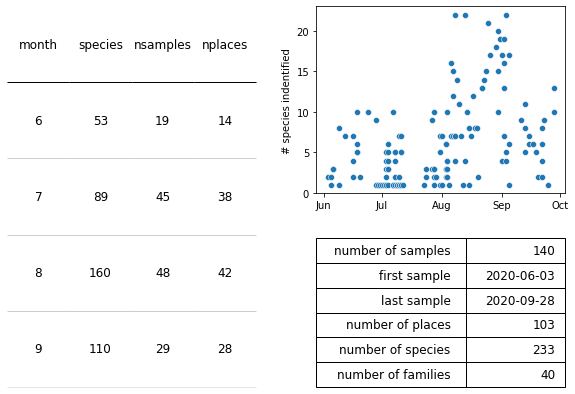

In [104]:
# Question is how moveable are the values?

# axone monthly summary values
t_one = spd1.groupby(["month"], as_index=False).agg({"species":"nunique", "loc_date":"nunique", "locname":"nunique"})

data = t_one.values
colLabels = [*t_one.columns[:-2], "nsamples", "nplaces"]
colWidths = [*[1/len(colLabels)]*len(colLabels)]
bbox = [0, 0,1,1]

# axtwo species identified per sample
d1 = spd1.groupby(["date", "locname"], as_index=False).species.count()

# axthree summary values
summary={
    "number of samples":spd1.loc_date.nunique(),
    "first sample": spd1["date"].min().date(),
    "last sample":spd1["date"].max().date(),
    "number of places":spd1.locname.nunique(),
    "number of species":spd1.species.nunique(),
    "number of families":spd1.fam.nunique(),    

}

a_summary = pd.DataFrame.from_dict(summary, orient="index").reset_index()


fig = plt.figure(figsize=(10,7))

gs = GridSpec(10,11)

axone = fig.add_subplot(gs[:, 0:5])
axtwo = fig.add_subplot(gs[0:5, 6:])
axthree = fig.add_subplot(gs[6:, 6:])

# axone
table_one = a_simple_formatted_table(axone,data,colLabels=colLabels, colWidths=colWidths, bbox=bbox)
axone.axis("off")

# axtwo
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
sns.scatterplot(data=d1, x="date", y="species", ax=axtwo)
axtwo.xaxis.set_major_locator(locator)
axtwo.xaxis.set_major_formatter(fmt)
axtwo.set_ylabel("# species indentified")
axtwo.set_xlabel("")

# axthree
b = a_single_column_table(axthree, a_summary.values, colWidths=[.6, .4])
axthree.axis("off")

plt.show()

Year 2 saw around 5x as many plants identified as in Year 1 due to the extra experience of the surveyor in identifying plants. In Year 3, given the extra experience of the surveyor, the expected number of observations will triple to around 18'000 - 22'000 observations through the year.

Not only has experience improved plant recognition significantly, but the survey method and data pipeline are now much smoother. On top of this the processes to organize and analyze the data are now in place so the survey team is much freer to focus on identifying plants and entering them in the infoflora app.

### Year two summary values

*__Below left:__ The number of species, samples and locations sampled per month. __Top right:__ The number of unique species identified per sample. __Bottom right:__ The aggregated values for year two.*

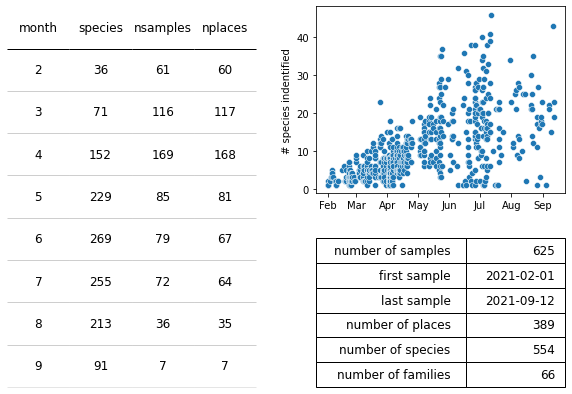

In [105]:
# get rid of any nan vals
spd2 = spd2.fillna(0)


# axone monthly summary values
t_one = spd2.groupby(["month"], as_index=False).agg({"species":"nunique", "loc_date":"nunique", "locname":"nunique"})

data = t_one.values
colLabels = [*t_one.columns[:-2], "nsamples", "nplaces"]
colWidths = [*[1/len(colLabels)]*len(colLabels)]
bbox = [0, 0,1,1]

# axtwo species identified per sample
d2 = spd2.groupby(["date", "locname"], as_index=False).species.count()

# axthree summary values
summary={
    "number of samples":spd2.loc_date.nunique(),
    "first sample": spd2["date"].min().date(),
    "last sample":spd2["date"].max().date(),
    "number of places":spd2.locname.nunique(),
    "number of species":spd2.species.nunique(),
    "number of families":spd2.fam.nunique(),    

}

a_summary = pd.DataFrame.from_dict(summary, orient="index").reset_index()


fig = plt.figure(figsize=(10,7))

gs = GridSpec(10,11)

axone = fig.add_subplot(gs[:, 0:5])
axtwo = fig.add_subplot(gs[0:5, 6:])
axthree = fig.add_subplot(gs[6:, 6:])

# axone
table_one = a_simple_formatted_table(axone,data,colLabels=colLabels, colWidths=colWidths, bbox=bbox)
axone.axis("off")

# axtwo
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
sns.scatterplot(data=d2, x="date", y="species", ax=axtwo)
axtwo.xaxis.set_major_locator(locator)
axtwo.xaxis.set_major_formatter(fmt)
axtwo.set_ylabel("# species indentified")
axtwo.set_xlabel("")

# axthree
b = a_single_column_table(axthree, a_summary.values, colWidths=[.6, .4])
axthree.axis("off")

plt.show()

### Red list observations 2020 2021

The number and category of observed species on the redlist for the region Middle Plateau

*__Below left:__ monthly cumulative observations of redlist species year one. __Below right:__ monthly cumulative observations of redlist species year two. __Bottom:__ Redlist categories identified per survey 2020 - 2021.*

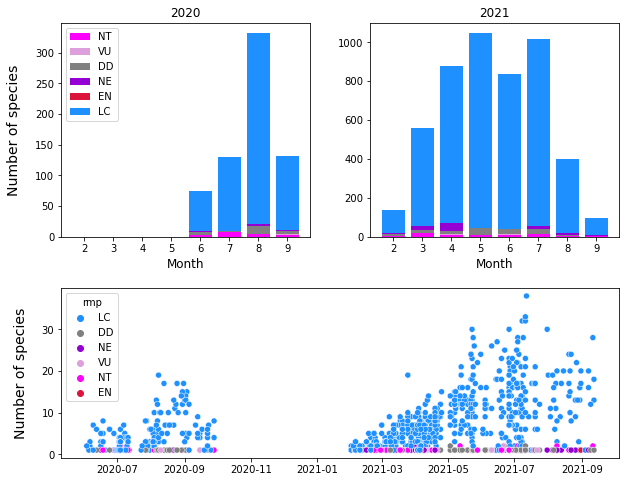

In [110]:
def periodic_value_counts(data, column, period="month", exclude=[]):
    a = data[~data[column].isin(exclude)]
    b = pd.DataFrame(a.groupby(period)[column].value_counts()).rename(columns={column:"data"})
    
    return b.reset_index()

def assgin_axis_values(data, period="month", column="rch", value="NT", these_dates=[], bars={}):
    
    a_dates = data[data[column]== value][period].unique()
    add_dates = [x for x in these_dates if x not in a_dates]
    add_these = [{period:x, column:aval, "data":0} for x in add_dates]
    data = data.append(add_these)
    bars.update({aval:{"data":data[data[column] == aval].sort_values(by="month")["data"].values}})
    
    return data, bars

# count the number of occurences for each category at each survey
these_years = [spd1, spd2]
these_dates = [x["month"].sort_values().unique() for x in these_years]
set_dates = list(set(these_dates[0]) | set(these_dates[1]))

these_lists = ["rch","ni", "inv", "ongen"]
not_these = ["X","-"]

period = "month"
column = "rmp"

biogeo = "mp"

a_palette = {
    "LC":"dodgerblue",
    "EN":"crimson",
    "NT":"magenta",
    "VU": "plum",
    "NE":"darkviolet",
    "DD":"grey",
}
    
    
    

# make bar for bar plots
# the unique values in the column of interest
e = list(set(spd1[column].unique()) | set(spd2[column].unique()))
e=[x for x in e if x not in not_these]

# year one
newDf = spd1[(spd1.biogeo == biogeo)&(~spd1[column].isin(not_these))]
data_rch_yone = periodic_value_counts(newDf, column, exclude=not_these)

red_list_yone_bars = {}
for aval in e:
    d_yone, _ = assgin_axis_values(data_rch_yone, period=period, column=column, value=aval, these_dates=set_dates, bars=red_list_yone_bars)

# year two
newDf2 = spd2[(spd2.biogeo == biogeo)&(~spd2[column].isin(not_these))]
data_rch_ytwo = periodic_value_counts(newDf2, column, exclude=not_these)

red_list_ytwo_bars = {}
for aval in e:
    d_ytwo,_ = assgin_axis_values(data_rch_ytwo, period=period, column=column, value=aval, these_dates=set_dates, bars=red_list_ytwo_bars)
    

# rmp status per survey
rmp_stat = pd.DataFrame(spd[~spd[column].isin(not_these)].groupby(["loc_date","date"]).rmp.value_counts()).rename(columns={column:"data"}).reset_index()



tick_spacing = 1

fig = plt.figure(figsize=(10,8))

gs = GridSpec(10,11)

axone = fig.add_subplot(gs[0:5, 0:5])
axtwo = fig.add_subplot(gs[0:5, 6:])
axthree = fig.add_subplot(gs[6:, :])

a_stacked_bar_chart(axone, red_list_yone_bars, xaxis=set_dates, palette=a_palette)
a_stacked_bar_chart(axtwo, red_list_ytwo_bars, xaxis=set_dates, palette=a_palette)

xlabel = "Month"
ylabel = "Number of species"


axone.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axone.set_ylabel(ylabel, fontsize=14, labelpad=14)
axone.set_xlabel(xlabel, fontsize=12)
axone.set_title("2020")
axone.legend()
axtwo.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axtwo.set_xlabel(xlabel, fontsize=12)
axtwo.set_title("2021")

sns.scatterplot(data=rmp_stat, x="date", y="data", hue="rmp", palette=a_palette, ax=axthree)
axthree.set_ylabel(ylabel, fontsize=14, labelpad=14)
axthree.set_xlabel("")

plt.show()   

__Monthly totals redlist observations__

*__Below left:__ Monthly totals for each redlist category year one. __Below right:__ Montlhy totals for each redlist catgegory year two. __Note:__ there were no samples recorded in Oct-Nov-Dec 2021*

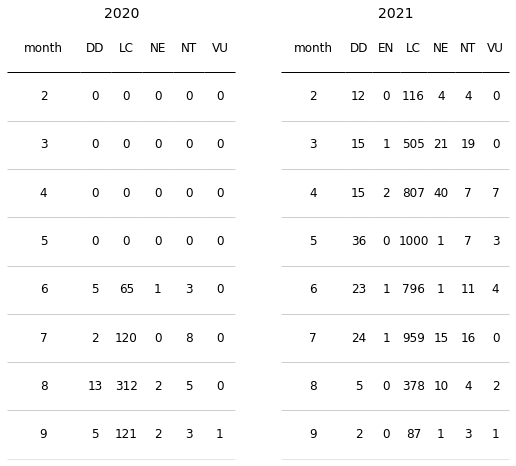

In [108]:
yone = d_yone.pivot(columns=column, index="month").fillna(0).astype("int")
yone.columns = yone.columns.get_level_values(1)
yone_columns = [x for x in yone.columns if x not in not_these]
yone = yone[yone_columns].reset_index()

ytwo = d_ytwo.pivot(columns=column, index="month").fillna(0).astype("int")
ytwo.columns = ytwo.columns.get_level_values(1)
ytwo_columns = [x for x in ytwo.columns if x not in not_these]
ytwo = ytwo[ytwo_columns].reset_index()

fig, ax = plt.subplots(1,2, figsize=(9,8))

axone = ax[0]
axtwo = ax[1]

# table one
table_one = a_simple_formatted_table(axone,yone.values,colLabels=yone.columns, colWidths=[.28, *[.12]*6], bbox=bbox)
axone.axis("off")
axone.set_title("2020", fontsize=14)

# table two
table_two = a_simple_formatted_table(axtwo, ytwo.values, colLabels=ytwo.columns, colWidths=[.28, *[.12]*6], bbox=bbox)
axtwo.axis("off")
axtwo.set_title("2021", fontsize=14)

plt.title("Monthly totals redlist observations"
plt.show()

In [109]:
# number of unique species identified and changes in top 10 genus, species, identified, red_list species, not_indigenous species
# number of instances and number of surveys
# numbers per survey
# series of monthly data, then series of quarterly data (feb-mar), (apr-may-jun),  (july-august-september-october)

In [88]:
# the data from year one

bar_data_yone = spd1.copy()

# the dates for the end of each month that
# has samples
# datesyone = spd1["month"].sort_values().unique()



# specify the values to count for each
# category - column


count_these = {}
for a_list in these_lists:
    count_these.update({a_list:[x for x in bar_data_yone[a_list].unique() if x not in not_these]})
    
# resample monthly totals:

 
barsyone={}
for a_list in these_lists:
    # for each category create an index of all months
    # with a sample
    month_index = pd.DataFrame(index=these_dates[1])
    month_index.index.name = resample
    
    # sum the occurences by month for each category in count_these
    l_data = bar_data_yone[bar_data_yone[a_list].isin(count_these[a_list])].groupby([resample], as_index=False)[a_list].value_count()
    b_data = l_data.groupby(resample)[a_list].sum()
    
    for data in b_data.index:
        month_index.loc[data, a_list]=b_data.loc[data]
    month_index.fillna(0, inplace=True)
    month_index.sort_index(inplace=True)
    
    barsyone.update({a_list: {"data": month_index.values.flatten()}})

TypeError: 'NoneType' object is not callable

In [89]:
barsyone

{}

In [90]:
bar_data = spd2.copy()
dates = index=spd2["month"].sort_values().unique()

these_lists = ["rch","ni", "inv", "ongen"]
resampkey = "M"
on="date"
by = "loc_date"

not_these = ["X", 0]


count_these = {}
for a_list in these_lists:
    count_these.update({a_list:[x for x in bar_data[a_list].unique() if x not in not_these]})
    
# resample monthly totals:
bars={}
for a_list in these_lists:
    # for each category create an index of all months
    # with a sample
    month_index = pd.DataFrame(index=spd2["month"].unique())
    month_index.index.name = "month"
    
    # sum the occurences by month for each category
    l_data = bar_data[bar_data[a_list].isin(count_these[a_list])].groupby(["month"], as_index=False)[a_list].count()
    b_data = l_data.groupby("month")[a_list].sum()
    
    for data in b_data.index:
        month_index.loc[data, a_list]=b_data.loc[data]
    month_index.fillna(0, inplace=True)
    month_index.sort_index(inplace=True)
    
    bars.update({a_list: {"data": month_index.values.flatten()}})

In [91]:
bars

{'rch': {'data': array([ 142.,  561.,  878., 1099.,  983., 1047.,  513.,  115.])},
 'ni': {'data': array([ 22.,  69., 147., 101.,  29.,  34.,  49.,   7.])},
 'inv': {'data': array([ 3.,  9., 29., 24., 75., 77., 40., 10.])},
 'ongen': {'data': array([  1.,  35., 108.,  69., 182., 116.,  43.,  12.])}}

NameError: name 'datesyone' is not defined

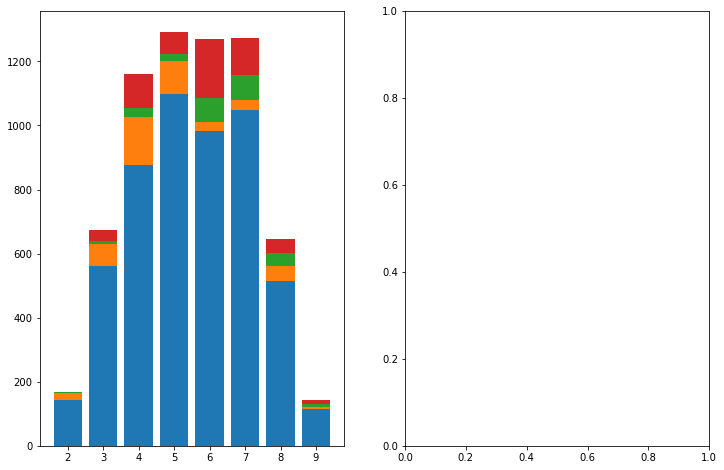

In [92]:
tick_spacing = 1

fig, axs = plt.subplots(1,2, figsize=(12, 8))
a_stacked_bar_chart(axs[0], bars, xaxis=dates)
a_stacked_bar_chart(axs[1], barsyone, xaxis=datesyone)
plt.legend()


axs[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


plt.show()   

In [93]:
spd2.columns

Index(['Unnamed: 0', 'date', 'species', 'year', 'biogeo', 'canton', 'river',
       'lot', 'forest', 'project', 'city', 'rch', 'rmp', 'rju', 'fam', 'res',
       'pri', 'inv', 'ode', 'ns', 'ongen', 'ni', 'cdf', 'biel', 'locname',
       'loc_date', 'genus', 'month'],
      dtype='object')

In [94]:
# monthly redlist break down
spd2.lot.unique()

array(['X', 'schwanen', 'none', 'flaess', 'taubenloch', 'jura', 'port'],
      dtype=object)

In [95]:
# location and lots
spd2.groupby(["lot"]).fam.nunique()

lot
X             66
flaess        19
jura          16
none          38
port          22
schwanen      29
taubenloch     5
Name: fam, dtype: int64

In [96]:
# detail of redlist columns for rch rmp
# compare to non lots 
spd2.groupby(["lot"]).rch.nunique()

lot
X             6
flaess        4
jura          2
none          2
port          3
schwanen      3
taubenloch    2
Name: rch, dtype: int64

In [97]:
# compare to non lots 
spd2.groupby(["project"]).loc_date.nunique()

project
X                560
pronat            13
renat-cygnes       5
renat-neumatt      3
renat-sund         1
renat-suze        41
renat-vor          1
schuessinsel       1
Name: loc_date, dtype: int64

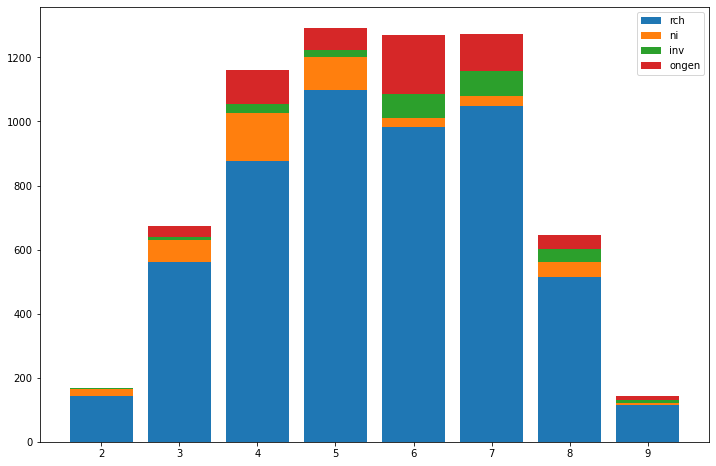

In [98]:
tick_spacing = 1

fig, ax = plt.subplots(figsize=(12, 8))
a_stacked_bar_chart(ax, bars, xaxis=dates)
plt.legend()


ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


plt.show()   

In [48]:
to_df = {x:bars[x]["data"] for x in bars.keys()}
tdf = pd.DataFrame(to_df, index=dates)
tdf

,rch,ni,inv,ongen
2,142.0,22.0,3.0,1.0
3,561.0,69.0,9.0,35.0
4,878.0,147.0,29.0,108.0
5,1099.0,101.0,24.0,69.0
6,983.0,29.0,75.0,182.0
7,1047.0,34.0,77.0,116.0
8,513.0,49.0,40.0,43.0
9,115.0,7.0,10.0,12.0


In [49]:
spd.groupby(["loc_date", ])

As we can see, the absolute and relative number of species identified went up as the year went on with a peak in early summer. Since the population diversity of herbaceous non grass flowering plants grows through the year and then peaks before going down again this is exactly to be expected. Notice that population of identified plants changes significantly through time as one might expect - each of the ten most common species and genus changes over time.

The second reason this is true is that the surveyor was not comfortable identifying most plants through leaves/rosettes and so species blooming later in the year would not be identified until then. This contribution to the skew in plants identified will go down in year three now that the surveyor has a strong basis in the local flora and can recognize future flowers based on leaf patterns for a significant number of the local species. If species cannot be identified, then genera can be also be more accurately noted.

An additional bias is that the surveyor collected a number of "empty" surveys of different areas with only some of the city trees in flower (such as corylus avellana) during February. This is not really an accurate represenation of the survey areas, even necessarily through the month of february and early march. As such, this data has been left out aside from a few early survey sites with some populations of flower plants. In other words, lots of empty values are left out. This will be addressed by including at least family level taxonomic identification (e.g. poaceae 1, poaceae 2, salix sp) even in places without the herbaceous vascual

The literature is clear that both late blooming and early blooming species are critically important for overwintering for small animals and especially insects. This will be taken into account to more accurately 

In [50]:
### Comparing lots, describing lots, there are four pulled out of the data here

lot_list = ["schwanen", "port", "taubenloch"]

sch = spd.loc[spd['lot'] == "schwanen"].copy()

por = spd.loc[spd['lot'] == "port"]

tau = spd.loc[spd['lot'] == "taubenloch"]

fla = spd.loc[spd["lot"] == "flaess"]


# Compare numbers in key categories (here, not indigenous, watch list, black list, near threatened in MP)
nisch = sch.loc[sch['ni'] =='ni']
wlsch = sch.loc[sch['inv'] =='WL']
blsch = sch.loc[sch['inv'] =='BL']
odesch = sch.loc[sch['ode'] == "ode"]
ntmpsch =  sch.loc[sch['rmp'] =='NT']
vumpsch =  sch.loc[sch['rmp'] =='VU']

print(F"there is {ntmpsch.species.nunique()} species on the NT list")
print(F"there is {wlsch.species.nunique()} species on the watch list")
print(F"there is {blsch.species.nunique()} species on the black list")
print(F"there is {odesch.species.nunique()} species on the ode list")
print(F"there is {vumpsch.species.nunique()} species on the vulnerable list")
print(F"there are {nisch.species.nunique()} non indigenous non invasive species")


there is 2 species on the NT list
there is 0 species on the watch list
there is 5 species on the black list
there is 0 species on the ode list
there is 0 species on the vulnerable list
there are 6 non indigenous non invasive species


In [51]:
# axone summary values of the lot
t_one = spd.groupby(["lot"], as_index=False).agg({"species":"nunique", "loc_date":"nunique", "locname":"nunique"})

data = t_one.values
colLabels = [*t_one.columns[:-2], "nsamples", "nplaces"]
colWidths = [*[1/len(colLabels)]*len(colLabels)]
bbox = [0, 0,1,1]

# axtwo species identified per sample
d = spd1.groupby(["date", "locname"], as_index=False).species.count()

# axthree summary values
summary={
    "number of samples":spd1.loc.nunique(),
    "first sample": spd1["date"].min().date(),
    "last sample":spd1["date"].max().date(),
    "number of places":spd1.locname.nunique(),
    "number of species":spd1.species.nunique(),
    "number of families":spd1.fam.nunique(),    

}

a_summary = pd.DataFrame.from_dict(summary, orient="index").reset_index()


fig = plt.figure(figsize=(10,7))

gs = GridSpec(10,11)

axone = fig.add_subplot(gs[:, 0:5])
axtwo = fig.add_subplot(gs[0:5, 6:])
axthree = fig.add_subplot(gs[6:, 6:])

# axone
table_one = a_simple_formatted_table(axone,data,colLabels=colLabels, colWidths=colWidths, bbox=bbox)
axone.axis("off")

# axtwo
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
sns.scatterplot(data=d, x="date", y="species", ax=axtwo)
axtwo.xaxis.set_major_locator(locator)
axtwo.xaxis.set_major_formatter(fmt)
axtwo.set_ylabel("# species indentified")
axtwo.set_xlabel("")

# axthree
b = a_single_column_table(axthree, a_summary.values, colWidths=[.6, .4])
axthree.axis("off")

plt.show()

AttributeError: '_LocIndexer' object has no attribute 'nunique'

In [52]:
spd.project.unique()

array(['X', 'renat-suze', 'renat-cygnes', 'pronat', 'renat-neumatt',
       'renat-sund', 'schuessinsel', 'renat-vor'], dtype=object)

In [53]:
# Describe and compare the renaturalization areas

cyg = spd.loc[spd['project'] == "renat-cygnes"].copy

suz = spd.loc[spd['project'] == "renat-suze"].copy

pro = spd.loc[spd['project'] == "pronat"].copy

neu = spd.loc[spd["project"] == "renat-neumatt"].copy

prosp = pro.species.unique()
prosp

AttributeError: 'function' object has no attribute 'species'

In [54]:
spd['species'].value_counts()[:15].index.tolist()
lots = spd[spd["lot"] != "X"]
lots['species'].value_counts()[:15].index.tolist()

['tussilago-farfara',
 'erigeron-annuus',
 'veronica-persica',
 'lotus-corniculatus',
 'taraxacum',
 'daucus-carota',
 'medicago-lupulina',
 'trifolium-repens',
 'galium-mollugo',
 'cirsium-arvense',
 'solidago-canadensis',
 'rumex-obtusifolius',
 'bellis-perennis',
 'trifolium-pratense',
 'plantago-lanceolata']

In [55]:
spd.river.unique()

array(['madretschkanal', 'schuessinsel', 'suze', 'neuenburgersee',
       'bielersee', 'orvine', 'leugene', 'emme', 'doubs', 'thunersee',
       'X', 'none', 'thun'], dtype=object)

In [56]:
# describe and compare the rivers: madretschkanal, suze, schuessinsel, and all suze length combined vs total

suz = spd.loc[spd['river'] == "suze"]

mad = spd.loc[spd['river'] == "madretschkanal"]

sch = spd.loc[spd['river'] == "schuessinsel"]

suz.head()

,Unnamed: 0,date,species,year,biogeo,canton,river,lot,forest,project,...,ode,ns,ongen,ni,cdf,biel,locname,loc_date,genus,month
65,66,2020-06-09,medicago-lupulina,1,mp,be,suze,X,X,X,...,X,X,X,X,cdf,biel,buerenstrasse-suze-1,"('buerenstrasse-suze-1', '09.06.2020')",medicago,6
66,67,2020-06-09,cichorium-intybus,1,mp,be,suze,X,X,X,...,X,X,X,X,cdf,biel,buerenstrasse-suze-1,"('buerenstrasse-suze-1', '09.06.2020')",cichorium,6
67,68,2020-06-09,potentilla-reptans,1,mp,be,suze,X,X,X,...,X,X,X,X,X,biel,buerenstrasse-suze-1,"('buerenstrasse-suze-1', '09.06.2020')",potentilla,6
68,69,2020-06-09,papaver-rhoeas,1,mp,be,suze,X,X,X,...,X,X,X,X,X,biel,buerenstrasse-suze-1,"('buerenstrasse-suze-1', '09.06.2020')",papaver,6
69,70,2020-06-09,hypericum-maculatum,1,mp,be,suze,X,X,X,...,X,X,X,X,cdf,biel,buerenstrasse-suze-1,"('buerenstrasse-suze-1', '09.06.2020')",hypericum,6
